In [1]:
library(tidyverse)
library(data.table)
library(repr)
library(gridExtra)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
repo_root <- normalizePath('../../')


In [3]:
dataset_list <- list(
#     'snpnet_biomarker' = c('biomarkers_20190407', 'biomarkers_20190407_multi_ethnic')
    'snpnet_biomarker' = c('biomarkers_20190407')    
)

In [4]:
get_stats_filename <- function(dataset_name, method_name, repo_root){
    file <- file.path(
        repo_root, 
        'public_output', 
        paste0(method_name, '_PRS'), 
        paste0(dataset_name, '.tsv')
    )
    return(file)
}

In [5]:
read_datasets <- function(method_name, named_dataset_list, repo_root){
    named_dataset_list[method_name][[1]] %>%
    lapply(               
        function(x){
            dataset_n <- str_split(x, '_') %>% simplify() %>% first()
            dataset_v <- str_split(x, '_') %>% simplify() %>% last()            
            df <- tryCatch(                
                x %>%
                get_stats_filename(method_name, repo_root) %>%
                fread(data.table=FALSE) %>%
                mutate(
                    method = method_name,
                    dataset_name = dataset_n,
                    dataset_version = dataset_v,
                    dataset_full = x
                ),
                error=function(e){NULL}
            )
            if(!is.null(df)) {
                colnames(df) <- gsub("^#", "", colnames(df))
            }
            df
        }
    ) %>%
    bind_rows()
}


In [6]:
read_all_data <- function(dataset_named_list, repo_root){
    dataset_named_list %>% names() %>% lapply(
        function(x){
            read_datasets(x, dataset_named_list, repo_root)
        }
    ) %>% 
    bind_rows() %>%
    replace_na(list(N = 0))
    
}

In [7]:
compute_delta <- function(df){
    df %>%
    spread(features, R_or_AUC) %>%
    mutate(
        delta_R_or_AUC = Genotype_and_covariates - Covariates_only
    ) %>% 
    gather(
        "features", "R_or_AUC", 
        c('Covariates_only', 'Genotype_only', 'Genotype_and_covariates', 'delta_R_or_AUC')
    ) %>%
    arrange(Population, GBE_ID)    
}


In [8]:
format_labels <- function(df){
    df %>% mutate(
        label = str_replace_all(GBE_ID, '_', ' '),
        label = str_replace_all(label, 'adjstatins', ''),
        label = str_replace_all(label, 'Normal', ''),
        label = str_replace_all(label, 'C reactive', 'C-reactive'),
        Population = str_replace(Population, 'white_british', 'White British'),
        Population = str_replace(Population, 'african', 'African'),
        Population = str_replace(Population, 's_asian', 'South Asian'),
        Population = str_replace(Population, 'e_asian', 'East Asian'),
        Population = str_replace(Population, 'non_british_white', 'Non-British White')        
    )    
}

In [9]:
final_list <- fread(
    'list_of_phes.txt', head=FALSE
)
colnames(final_list) <- c('GBE_ID')

In [10]:
df <- dataset_list %>% read_all_data(repo_root) %>% 
inner_join(final_list) %>% 
replace_na(list(Population = 'white_british')) %>%
select(-method, -PRS_model, -dataset_name, -dataset_version, -dataset_full)

ERROR: Error: `x` must be a vector


In [76]:
df %>% dim() %>% print()
df %>% select(GBE_ID) %>% unique() %>% count() %>% print()

[1] 570   5
# A tibble: 1 x 1
      n
  <int>
1    38


In [13]:
p1 <- df %>% compute_delta() %>% format_labels() %>% spread(features, R_or_AUC) %>%
filter(Population == 'White British') %>%
ggplot(
    aes(x = reorder(label, delta_R_or_AUC), y=delta_R_or_AUC)
)+ theme_bw() + 
theme(
    strip.text = element_text(size=7)
    )+ 
coord_flip()+
geom_bar(stat = 'identity') +
labs(
    x = 'Phenotype',
    y = expression("Increments in predictive performance with genotype ("*Delta*"R or "*Delta*"AUC)")
)

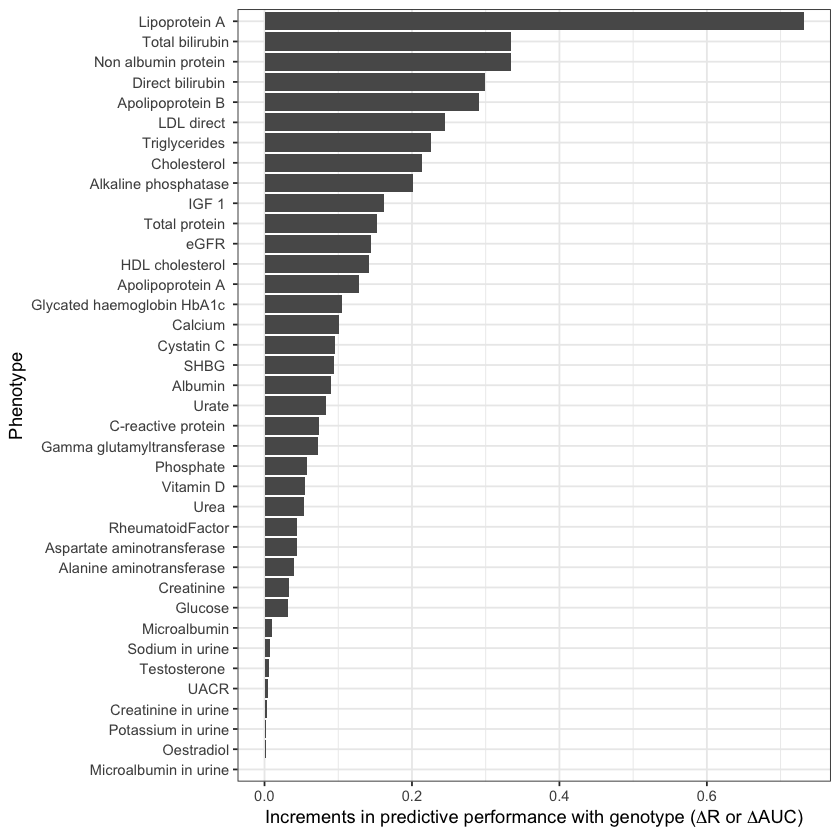

In [14]:
plot_width <- 7
plot_height <- 7
options(repr.plot.width=plot_width , repr.plot.height=plot_height)
p1
ggsave('snpnet.png', width=plot_width, height=plot_height)

### save data table

In [15]:
df_tabulated <- df %>% compute_delta() %>% format_labels() %>% mutate(Phenotype = label) %>% spread(features, R_or_AUC) %>%
select(Phenotype, phe_type, Population, delta_R_or_AUC, Genotype_and_covariates, Covariates_only, Genotype_only)

In [20]:
df_tabulated_WB <- df_tabulated %>% filter(Population == 'White British') %>% 
rename(
    WB_delta_R_or_AUC          = delta_R_or_AUC,
    WB_Genotype_and_covariates = Genotype_and_covariates,
    WB_Covariates_only         = Covariates_only, 
    WB_Genotype_only           = Genotype_only
) %>% select(
    -phe_type, -Population
)

In [21]:
df_tabulated_full <- df_tabulated %>% left_join(
    df_tabulated_WB, by='Phenotype'
) %>% 
mutate(
    Relative_to_WB_delta_R_or_AUC          = 100 * delta_R_or_AUC          / WB_delta_R_or_AUC, 
    Relative_to_WB_Genotype_and_covariates = 100 * Genotype_and_covariates / WB_Genotype_and_covariates,
    Relative_to_WB_Covariates_only         = 100 * Covariates_only         / WB_Covariates_only, 
    Relative_to_WB_Genotype_only           = 100 * Genotype_only           / WB_Genotype_only
) %>% 
arrange(phe_type, Phenotype, Population)

In [22]:
df_tabulated_full %>% select(
    -WB_delta_R_or_AUC, -WB_Genotype_and_covariates, -WB_Covariates_only, -WB_Genotype_only
) %>% 
fwrite(
    'snpnet_performance.tsv', sep='\t'
)

### summary of performance reduction

In [89]:
df_tabulated_full %>% 
# filter(Population != 'White British') %>%
select(Phenotype, phe_type, Population, Relative_to_WB_delta_R_or_AUC, delta_R_or_AUC, WB_delta_R_or_AUC) %>% 
group_by(Population) %>% 
summarise(
    max = max(as.numeric(Relative_to_WB_delta_R_or_AUC), na.rm = TRUE),
    median = median(as.numeric(Relative_to_WB_delta_R_or_AUC), na.rm = TRUE),
    min = min(as.numeric(Relative_to_WB_delta_R_or_AUC), na.rm = TRUE)
) %>%
mutate(
    median_reduction = 100 - median
)

Population,max,median,min,median_reduction
African,113.19690,28.03202,-Inf,71.967984
East Asian,85.92474,56.83065,-306.40175,43.169354
Non-British White,144.49656,93.64275,-11.81403,6.357245
South Asian,183.50089,69.96337,-31.23773,30.036629
White British,100.00000,100.00000,100.00000,0.000000


In [72]:
df_tabulated_full %>% 
filter(Population != 'White British') %>%
select(Phenotype, phe_type, Population, Relative_to_WB_delta_R_or_AUC, delta_R_or_AUC, WB_delta_R_or_AUC) %>% 
drop_na() %>%
# filter(delta_R_or_AUC >= 0) %>%
group_by(Population) %>% 
mutate(
    rank = rank(-as.numeric(Relative_to_WB_delta_R_or_AUC), ties.method="min")
) %>% ungroup() %>% 
filter(
    rank <= 3
) %>% arrange(Population, rank)

Phenotype,phe_type,Population,Relative_to_WB_delta_R_or_AUC,delta_R_or_AUC,WB_delta_R_or_AUC,rank
Potassium in urine,qt,African,113.19690,0.00284860,0.0025165,1
Total bilirubin,qt,African,84.76735,0.28358450,0.3345445,2
Direct bilirubin,qt,African,77.65492,0.23230680,0.2991527,3
Albumin,qt,East Asian,85.92474,0.07784060,0.0905916,1
UACR,bin,East Asian,82.07646,0.00361120,0.0043998,2
Total protein,qt,East Asian,80.93086,0.12346990,0.1525622,3
Creatinine in urine,qt,Non-British White,144.49656,0.00434400,0.0030063,1
Sodium in urine,qt,Non-British White,144.36084,0.01062900,0.0073628,2
UACR,bin,Non-British White,105.11160,0.00462470,0.0043998,3
Potassium in urine,qt,South Asian,183.50089,0.00461780,0.0025165,1


In [75]:
df_tabulated_full %>% 
filter(Population != 'White British') %>%
select(Phenotype, phe_type, Population, Relative_to_WB_delta_R_or_AUC, delta_R_or_AUC, WB_delta_R_or_AUC) %>% 
drop_na() %>%
filter(WB_delta_R_or_AUC >= 0.1) %>%
group_by(Population) %>% 
mutate(
    rank = rank(-as.numeric(Relative_to_WB_delta_R_or_AUC), ties.method="min")
) %>% ungroup() %>% 
filter(
    rank <= 3
) %>% arrange(Population, rank)

Phenotype,phe_type,Population,Relative_to_WB_delta_R_or_AUC,delta_R_or_AUC,WB_delta_R_or_AUC,rank
Total bilirubin,qt,African,84.76735,0.2835845,0.3345445,1
Direct bilirubin,qt,African,77.65492,0.2323068,0.2991527,2
LDL direct,qt,African,57.06355,0.1396393,0.2447084,3
Total protein,qt,East Asian,80.93086,0.1234699,0.1525622,1
Calcium,qt,East Asian,76.41454,0.0772956,0.1011530,2
HDL cholesterol,qt,East Asian,73.01374,0.1032610,0.1414268,3
Calcium,qt,Non-British White,102.31906,0.1034988,0.1011530,1
Direct bilirubin,qt,Non-British White,101.25959,0.3029208,0.2991527,2
Total bilirubin,qt,Non-British White,100.43579,0.3360024,0.3345445,3
Alkaline phosphatase,qt,South Asian,112.19078,0.2263449,0.2017500,1


### plots

In [101]:
p2 <- df_tabulated_full %>% 
filter(Population != 'White British') %>%
mutate(
    label = if_else(Population == 'Non-British White', Phenotype, ''),
) %>%
rename(score = delta_R_or_AUC, WB_score = WB_delta_R_or_AUC) %>%
select(Phenotype, Population, score, WB_score, label) %>%
ggplot(aes(x = WB_score, y=score, color=Population, shape=Population, label=label))+ 
theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position = c(0.25, 0.8)
)+ 
geom_abline(slope=1, intercept=0, linetype = "dashed") + 
geom_point(stat = 'identity') +
xlim(0, .75) + ylim(0, .75) + 
labs(
    x = 'Increments in predictive performance for White British',
    y = 'Increments in predictive performance for non-White British populations',
    color = 'Non-White British population',
    shape = 'Non-White British population'
) + 
ggrepel::geom_text_repel(size=2) + 
scale_color_brewer(palette="Dark2")

Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing missing values (geom_text_repel).”Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing missing values (geom_text_repel).”

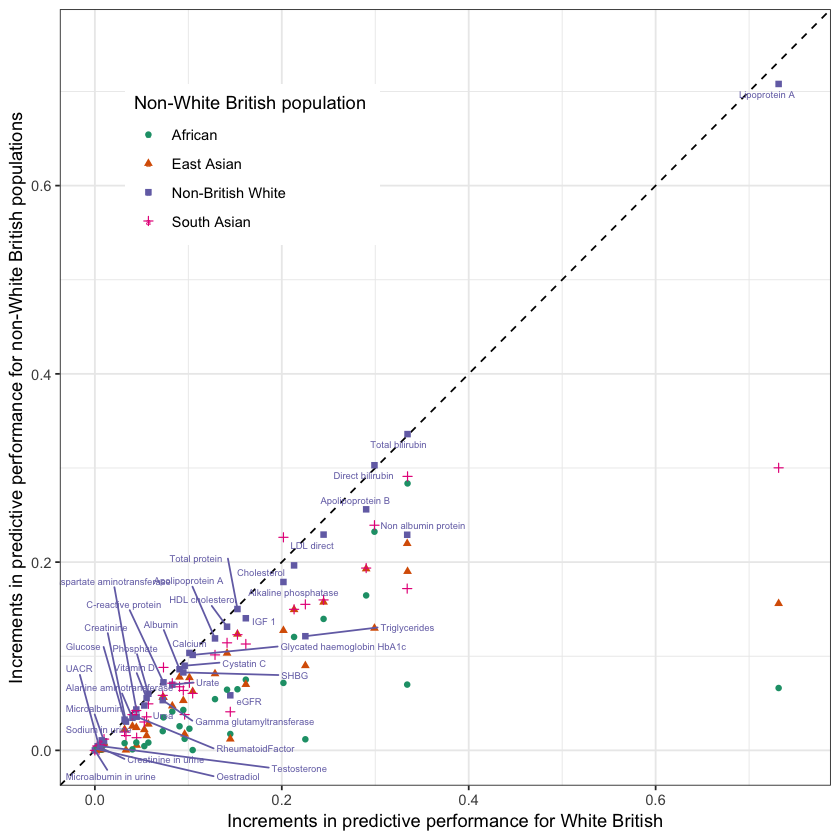

In [102]:
plot_width <- 7
plot_height <- 7
options(repr.plot.width=plot_width , repr.plot.height=plot_height)
p2
ggsave('snpnet-multi-ethnic-delta.png', width=plot_width, height=plot_height)

In [103]:
p3 <- df_tabulated_full %>% 
filter(Population != 'White British') %>%
mutate(
    label = if_else(Population == 'Non-British White', Phenotype, ''),
) %>%
rename(score = Genotype_and_covariates, WB_score = WB_Genotype_and_covariates) %>%
select(Phenotype, Population, score, WB_score, label) %>%
ggplot(aes(x = WB_score, y=score, color=Population, shape=Population, label=label))+ 
theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position = c(0.2, 0.8)
)+ 
geom_abline(slope=1, intercept=0, linetype = "dashed") + 
geom_point(stat = 'identity') +
xlim(0, 1) + ylim(0, 1) + 
labs(
    x = 'Predictive performance for White British',
    y = 'Predictive performance for non-White British populations',
    color = 'Non-White British population',
    shape = 'Non-White British population'
) + 
ggrepel::geom_text_repel(size=2) + 
scale_color_brewer(palette="Dark2")

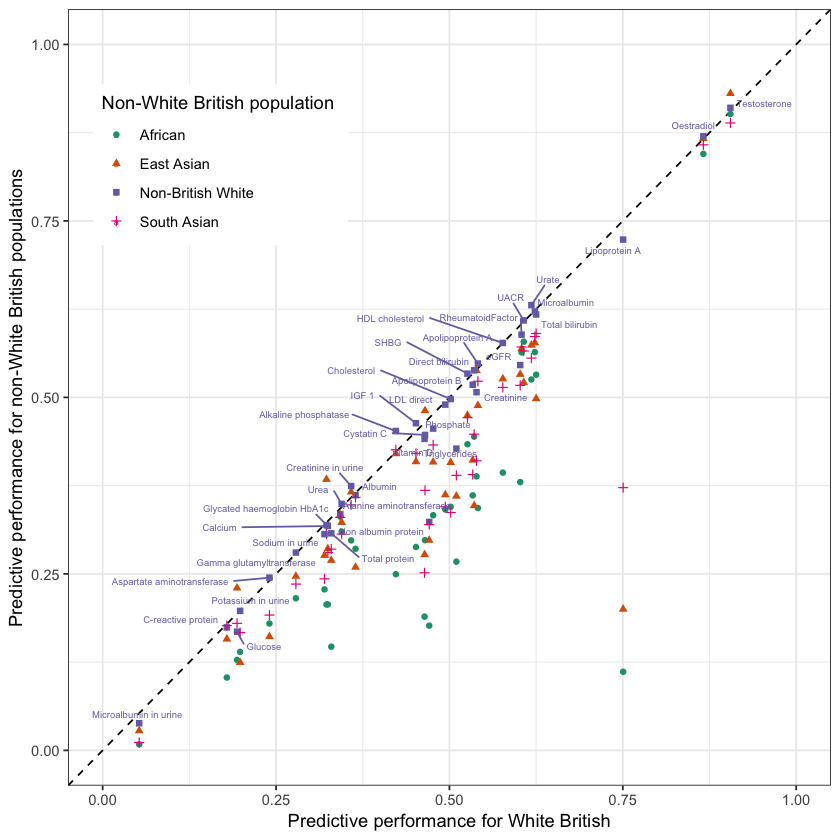

In [104]:
plot_width <- 7
plot_height <- 7
options(repr.plot.width=plot_width , repr.plot.height=plot_height)
p3
ggsave('snpnet-multi-ethnic.png', width=plot_width, height=plot_height)

Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing missing values (geom_text_repel).”

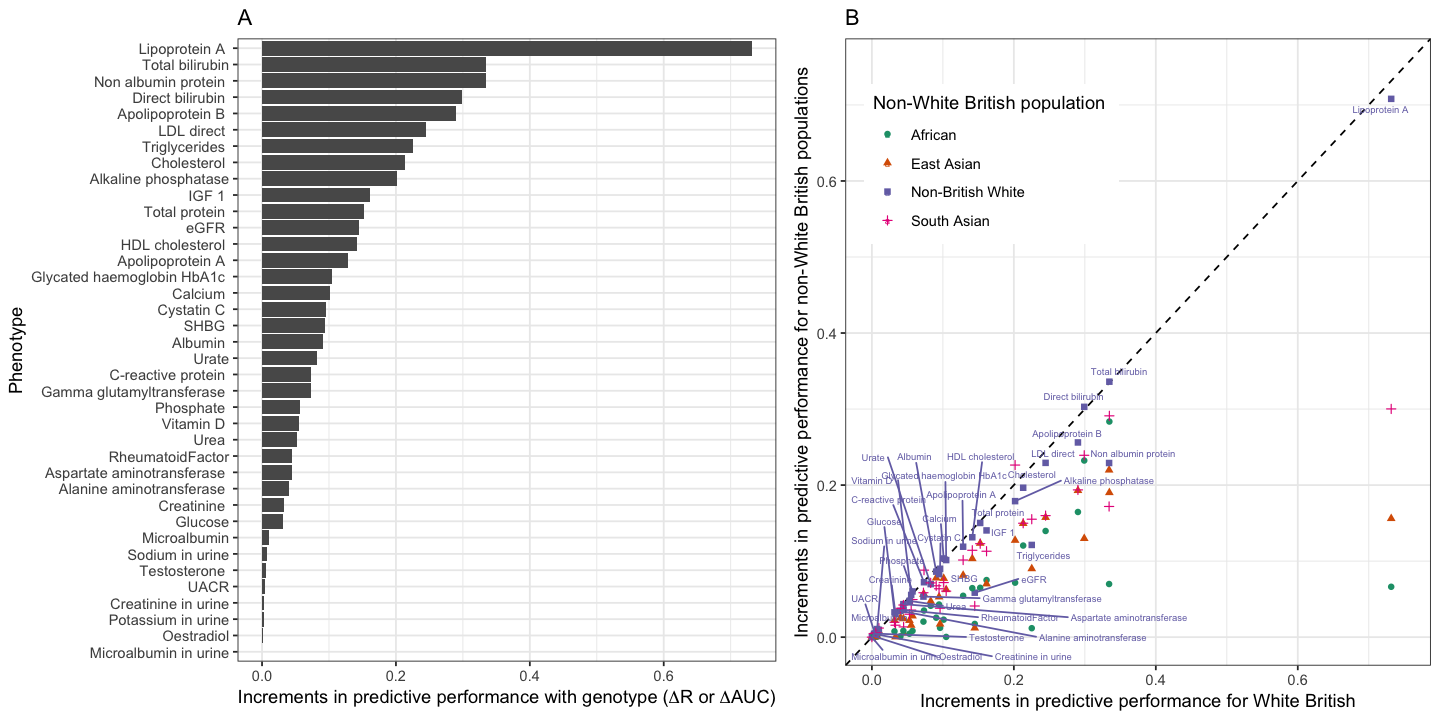

In [108]:
plot_width <- 12
plot_height <- 6
options(repr.plot.width=plot_width , repr.plot.height=plot_height)
p_combined <- grid.arrange(
    p1 + labs(title='A') , 
    p2 + labs(title='B'), # + scale_color_brewer(palette="Set2"), 
    widths = c(1.2, 1), nrow = 1
)

In [109]:
ggsave('snpnet-combined.png', p_combined, width = plot_width , height=plot_height)

In [39]:
bias_df <- df %>% compute_delta() %>% format_labels() %>% filter(features == 'delta_R_or_AUC') %>% 
spread(Population, R_or_AUC) %>%
gather("Population", "R_or_AUC", c('White British', 'African', 'East Asian', 'South Asian', 'Non-British White')) %>%
group_by(GBE_ID)%>%
mutate(
    rank_R_or_AUC = rank(-R_or_AUC, ties.method="min"),
    rank_R_or_AUC = paste0('Rank_', rank_R_or_AUC)
) %>%
ungroup() %>%
count(Population, rank_R_or_AUC) %>%
spread(rank_R_or_AUC, n, fill =0) %>%
arrange(-Rank_1, -Rank_2, -Rank_3, -Rank_4, -Rank_5)

In [40]:
bias_df

Population,Rank_1,Rank_2,Rank_3,Rank_4,Rank_5
White British,23,14,1,0,0
Non-British White,11,18,7,2,0
South Asian,6,4,19,7,2
East Asian,1,0,8,22,7
African,0,1,2,6,29


In [41]:
bias_df %>% 
fwrite('PRS_bias.tsv', row.names=F, col.names=T, sep='\t')

#### here is the status of the jobs

In [42]:
df %>% filter(
    features == 'Genotype_and_covariates',
) %>% count(
    Population, GBE_ID
) %>% spread(
    Population, n, fill =0
) %>% 
right_join(final_list)

Joining, by = "GBE_ID"


GBE_ID,african,e_asian,non_british_white,s_asian,white_british
Alanine_aminotransferase_adjstatins,1,1,1,1,1
Albumin_adjstatins,1,1,1,1,1
Alkaline_phosphatase,1,1,1,1,1
Apolipoprotein_A_adjstatins,1,1,1,1,1
Apolipoprotein_B_adjstatins,1,1,1,1,1
Aspartate_aminotransferase_adjstatins,1,1,1,1,1
Calcium_adjstatins,1,1,1,1,1
Cholesterol_adjstatins,1,1,1,1,1
C_reactive_protein_adjstatins,1,1,1,1,1
Creatinine_adjstatins,1,1,1,1,1


### previous notebooks

In [23]:
plot_width <- 10
plot_height <- 30
options(repr.plot.width=plot_width , repr.plot.height=plot_height)

In [24]:
p <- df %>% 
mutate(
    adj_statins = if_else(endsWith(GBE_ID, '_adjstatins'), 'Yes', 'No', missing = NULL),
    phe_name = str_replace(str_replace(GBE_ID, '_adjstatins$', ''), '_', ' ')
) %>%
ggplot(
    aes(x = adj_statins, y=R_or_AUC, fill = adj_statins)
) + 
geom_bar(stat = 'identity') + 
facet_grid(phe_name~features, space='free_x') +
theme(
    axis.title.x=element_blank(),
#     axis.text.x = element_text(angle = 30, hjust = 1),    
    axis.text.x=element_blank(),    
    axis.ticks.x=element_blank(),
    legend.position="bottom"
) + 
labs(
    y = 'R or AUC',
    title = 'Biomarker run results (2019/4/7)',
    fill = 'Statins adjustment'
) + 
scale_fill_brewer(palette = "Set2") +
guides(fill=guide_legend(nrow=2,byrow=TRUE))

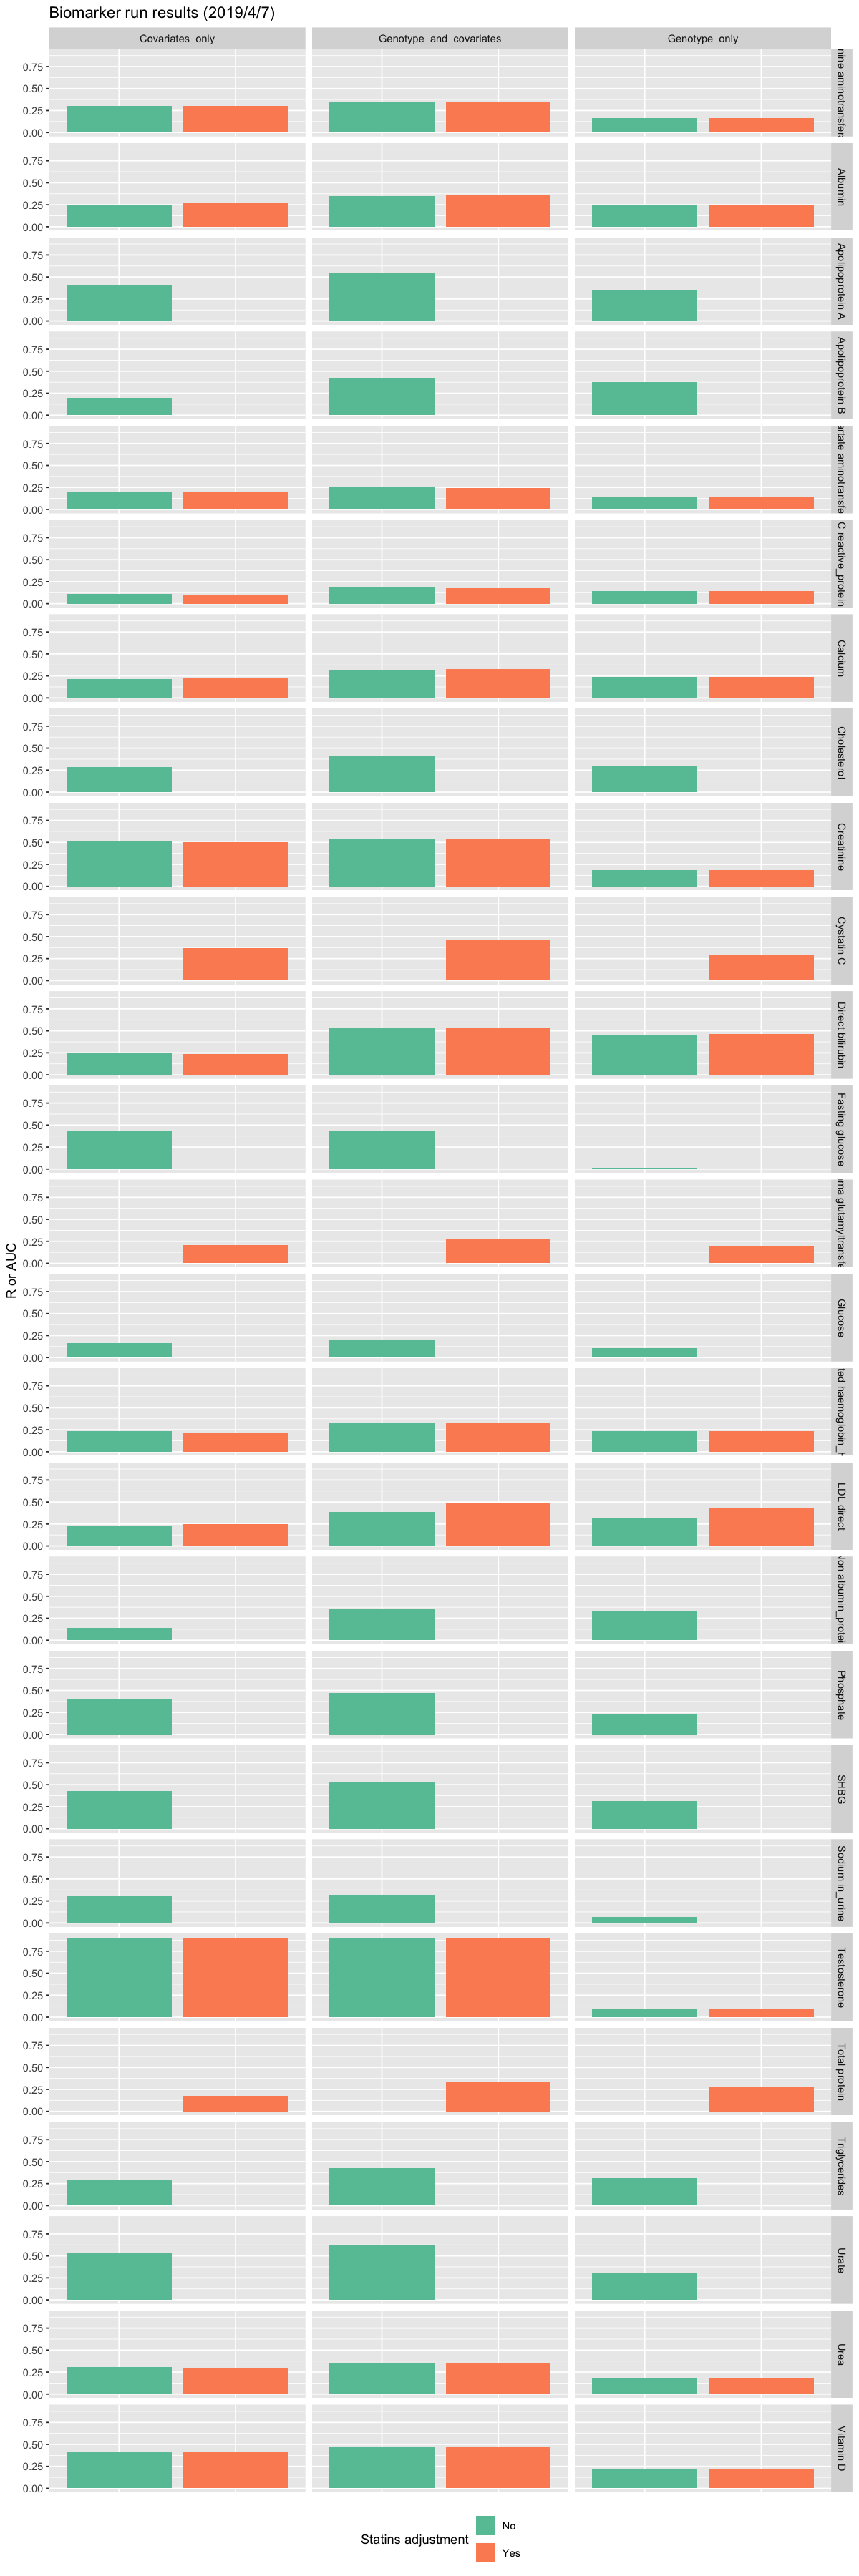

In [25]:
p + ggsave(
    'snpnet_biomarkers_20190407.png',
    width = plot_width, height = plot_height
)
